## Setting up

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

from rich import print
from calendar import isleap

In [2]:
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

## Loading in and processing the data input

In [3]:
# Loading in discharge data from the measuring station Katima Mulilo
km = (pd.read_csv('Katima_Mulilo/1291100_Q_Day.txt', skiprows=35, delimiter=';', header=1)
      .drop(columns=['hh:mm'])
      .rename(columns={'YYYY-MM-DD': 'Date', ' Value': 'Discharge [m^3/s]'}))

# Removing nans
km['Discharge [m^3/s]'] = km['Discharge [m^3/s]'].replace(-999.000, np.nan)

# Adjusting the data-set to datetime format
km['Date'] = pd.to_datetime(km['Date'])
km['Year'] = km['Date'].dt.year
km['Day'] = km['Date'].dt.dayofyear

# Defining the data period
start_calibration = '1986-11-01'
end_calibration = '2019-10-31'
start_hydro_year = 1987
end_hydro_year = 2019

# Reducing the dataframe to the calibration period
km = km[(km['Date'] >= start_calibration) & (km['Date'] <= end_calibration)]

In [4]:
# Loading in critical inflow per hydraulic year
Q_crit = (pd.read_csv('Katima_Mulilo/critical_inflow.csv', usecols=[0, 3, 4, 6], delimiter=';', decimal='.')
          .rename(columns={'Year': 'hydro_year', 'Annual Power demand Zambia [MW]': 'power_demand_zambia [MW]', 'Annual Power demand Zimbabwe [MW]': 'power_demand_zimbabwe [MW]', 
                           'Required inflow at Katima Mulilo [m^3/s]': 'Q_crit'}))

## Determining the start of the water-year

In [5]:
year = km['Year'].unique()

year_start = []

for i in year:
    yearly_data = km[km['Year'] == i].reset_index()
    year_start.append(yearly_data['Discharge [m^3/s]'].idxmin())

year_start = year_start[1:-1]
avg_minday = np.mean(year_start)
print(f'The average lowest point of the Zambezi discharge is the {avg_minday:.0f}th day of the year. This is precisely the last day of October, so the first day of November is the average start of the hydraulic year.')

The average lowest point of the Zambezi discharge is the 306th day of the year. This is precisely the last day of 
October, so the first day of November is the average start of the hydraulic year.

## A quick visual presentation of the flow

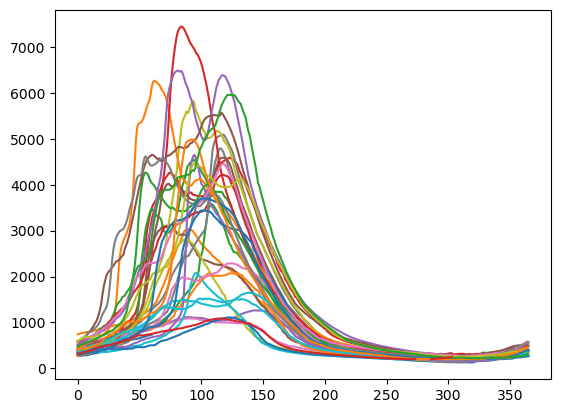

In [6]:
for j in year:
    yearly_data = km[km['Year'] == j].reset_index()
    yearly_data['Discharge [m^3/s]'].plot()

## Adapting the datasets to the start of the hydraulic year

In [7]:
km['hydro_year'] = np.where(km['Day'] < 305, km['Year'], km['Year'] + 1)
Q_crit = Q_crit[(Q_crit['hydro_year'] >= start_hydro_year) & (Q_crit['hydro_year'] <= end_hydro_year)]

## Drought analyser

In [8]:
def analyse_annual_deficits_MW(daily_data, flow_col, year_col, Q_crit, demand_zambia, demand_zimbabwe, eta=0.9, rho=1000, g=9.81, head=110.5):
    deficityears = []

    for year, group in daily_data.groupby(year_col):
        group[flow_col] = pd.to_numeric(group[flow_col], errors='coerce')

        total_deficit = (Q_crit - group[flow_col]).clip(lower=0).sum()
        total_surplus = (group[flow_col] - Q_crit).clip(lower=0).sum()

        if total_deficit > total_surplus:
            avg_net_deficit = (total_deficit - total_surplus) / len(group)
            power_shortage_MW = (eta * rho * g * avg_net_deficit * head) / 1e6

            shared_shortage_MW = power_shortage_MW / 2

            shortage_pct_zambia = round(100 * shared_shortage_MW / demand_zambia, 2)
            shortage_pct_zimbabwe = round(100 * shared_shortage_MW / demand_zimbabwe, 2)
            average_shortage = (shortage_pct_zambia + shortage_pct_zimbabwe) / 2
            
            if average_shortage >= 55:
                deficityears.append({'hydro_year': year, 'avg_net_deficit_m^3/s': round(avg_net_deficit, 2), 'power_shortage_MW': round(power_shortage_MW, 2),
                'Zambia_shortage_%': shortage_pct_zambia, 'Zimbabwe_shortage_%': shortage_pct_zimbabwe, 'severity': 'critical'})
            if 25 <= average_shortage < 55:
               deficityears.append({'hydro_year': year, 'avg_net_deficit_m^3/s': round(avg_net_deficit, 2), 'power_shortage_MW': round(power_shortage_MW, 2),
                'Zambia_shortage_%': shortage_pct_zambia, 'Zimbabwe_shortage_%': shortage_pct_zimbabwe, 'severity': 'high'})
            if average_shortage < 25:
                deficityears.append({'hydro_year': year, 'avg_net_deficit_m^3/s': round(avg_net_deficit, 2), 'power_shortage_MW': round(power_shortage_MW, 2),
                'Zambia_shortage_%': shortage_pct_zambia, 'Zimbabwe_shortage_%': shortage_pct_zimbabwe, 'severity': 'mild'})

    return pd.DataFrame(deficityears)

## Finding historical droughts

In [9]:
historic_droughts = analyse_annual_deficits_MW(km, 'Discharge [m^3/s]', 'hydro_year', 1466.820 , 730, 760)

In [10]:
historic_droughts.style.hide(axis="index")

hydro_year,avg_net_deficit_m^3/s,power_shortage_MW,Zambia_shortage_%,Zimbabwe_shortage_%,severity
1987,456.310000,445.180000,30.490000,29.290000,high
1988,549.200000,535.800000,36.700000,35.250000,high
1990,841.350000,820.830000,56.220000,54.000000,critical
1991,501.640000,489.400000,33.520000,32.200000,high
1992,911.320000,889.090000,60.900000,58.490000,critical
1993,358.490000,349.750000,23.960000,23.010000,mild
1994,708.950000,691.650000,47.370000,45.500000,high
1995,955.370000,932.070000,63.840000,61.320000,critical
1996,1043.970000,1018.500000,69.760000,67.010000,critical
1997,771.500000,752.680000,51.550000,49.520000,high


<Axes: >

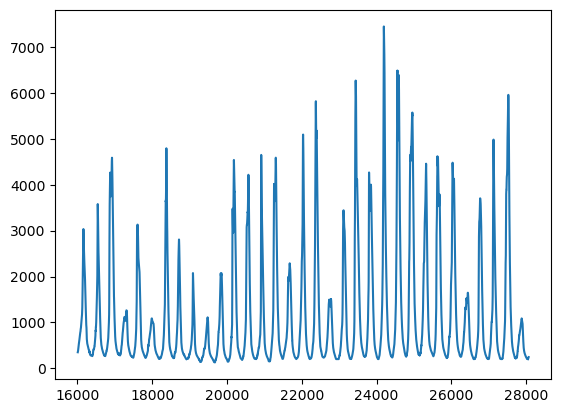

In [14]:
km['Discharge [m^3/s]'].plot()